In [1]:
########## SECTION 1 - Importing Required Packages and Functions ###############################
import pandas as pd
import numpy as np 
from simulate import generateData
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
from scipy.optimize import linprog

In [2]:
########## SECTION 2 - Generating Simulated Dataset ############################################

# number of observations
n=4000

# number of (Gaussian) covariates
p=20

# signal strength
signal_strength = 5

# Parameters for Distribution to draw Betas from. Betas ~ N(mu, stdev^2)
mu = 0
stdev = 1.0

# Generate the data
# - X is an (n,p+1) dimensional array with the n rows corresponding to observations and the p+1 columns
#   corresponding to the covariates + a column of 1's (for the intercept term)
# - Beta is the (p+1,) dimensional array of 'True' regression coefficients
# - y is the (n,) dimensional array of response values for the observations
# - means is the (n,) dimensional array of predicted values (probabilities in case of logistic)
# *THOUGHT: Perhaps we could use another term instead of means to avoid confusion with the systematic component?
# * perhaps y_hat, preds, etc?
X, Beta, y, means = generateData(dist = 'bernoulli', n = n, p = p, mu = mu, stdev = stdev, signal_strength = signal_strength) 

In [3]:
# Sanity Check 1: Should be equal to signal strength
Beta.dot(Beta)/n

5.000000000000001

In [4]:
# Sanity check 2 - Ignore
#from simulate import generateRandomBeta
#beta = generateRandomBeta(q=p, mu=mu, stdev=stdev)
#bb = beta * np.sqrt( (n * signal_strength) / beta.T.dot(beta).values[0,0] )
#bb.values.T.dot(bb.values)/n # check

In [5]:
# Combining the predictor and response data into a single pandas dataframe df
df = pd.DataFrame(X)
y = np.array(y)
y = np.where(y>0,1,-1)# Changed label 0 to -1, For convenience, we choose the label as {-1,1} instead of {0,1}
df['y'] = pd.Series(y)

(array([ 84., 114.,  85.,  72.,  69.,  62.,  58.,  45.,  52.,  58.,  44.,
         42.,  43.,  43.,  44.,  48.,  46.,  33.,  34.,  34.,  37.,  30.,
         34.,  29.,  30.,  34.,  29.,  40.,  34.,  28.,  37.,  21.,  31.,
         17.,  23.,  38.,  40.,  25.,  25.,  26.,  29.,  23.,  24.,  23.,
         28.,  38.,  26.,  41.,  25.,  25.,  25.,  22.,  16.,  36.,  33.,
         31.,  36.,  22.,  32.,  31.,  21.,  21.,  24.,  27.,  31.,  28.,
         26.,  22.,  38.,  29.,  34.,  38.,  32.,  39.,  40.,  24.,  34.,
         34.,  47.,  45.,  46.,  29.,  40.,  37.,  28.,  45.,  44.,  57.,
         45.,  44.,  44.,  41.,  47.,  65.,  65.,  63.,  70.,  99.,  81.]),
 array([2.84216295e-04, 1.02746139e-02, 2.02650114e-02, 3.02554090e-02,
        4.02458065e-02, 5.02362041e-02, 6.02266017e-02, 7.02169992e-02,
        8.02073968e-02, 9.01977943e-02, 1.00188192e-01, 1.10178589e-01,
        1.20168987e-01, 1.30159385e-01, 1.40149782e-01, 1.50140180e-01,
        1.60130577e-01, 1.70120975e-01, 1.80

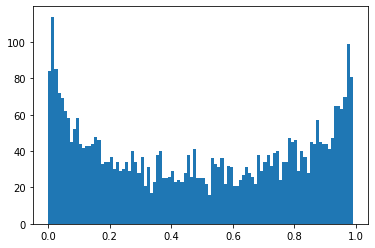

In [6]:
# QUICK ASIDE...
# Looking at distribution of means
import matplotlib.pyplot as plt
min_mean = min(means)
max_mean = max(means)
plt.hist(means, bins=np.arange(min_mean, max_mean, (max_mean-min_mean)/100))

(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   3.,   3.,   2.,   1.,
          0.,   6.,   2.,   4.,   1.,   3.,  12.,   7.,   6.,  11.,  15.,
          6.,  16.,  25.,  26.,  28.,  30.,  20.,  41.,  36.,  38.,  42.,
         46.,  55.,  52.,  49.,  70.,  68.,  65.,  74.,  93.,  85.,  84.,
         85.,  91., 101.,  97.,  92., 110.,  97., 109., 113.,  97., 117.,
         95.,  97.,  96., 108., 107.,  89., 114.,  88.,  69.,  87.,  84.,
         66.,  61.,  43.,  58.,  62.,  47.,  45.,  39.,  33.,  41.,  30.,
         36.,  24.,  17.,  18.,  16.,  17.,  17.,   8.,  14.,   5.,   4.,
          3.,   3.,   7.,   4.,   2.,   3.,   0.,   1.,   2.,   1.,   3.]),
 array([-8.16549075, -8.01084984, -7.85620893, -7.70156803, -7.54692712,
        -7.39228621, -7.2376453 , -7.08300439, -6.92836348, -6.77372257,
        -6.61908166, -6.46444075, -6.30979984, -6.15515894, -6.00051803,
        -5.84587712, -5.69123621, -5.5365953 , -5.38195439, -5.22731348,
        -5.07267257, -4.91803166, -4.763

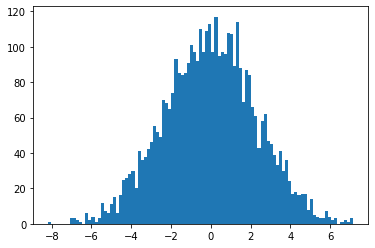

In [7]:
# Looking at distribution of systematic components (would prefer to call these the "means")
sys = X.dot(Beta)
min_sys = min(sys)
max_sys = max(sys)
plt.hist(sys, bins=np.arange(min_sys, max_sys, (max_sys-min_sys)/100))

In [8]:
# Checking percentiles of 'sys'. For signal strength of 5, 2.5th percentile should be > ~-4.472
# and 97.5th percentile should be < ~4.472
print(' 2.5th percentile: '+str(np.percentile(sys,2.5)))
print('97.5th percentile: '+str(np.percentile(sys,97.5)))

 2.5th percentile: -4.44236836602017
97.5th percentile: 4.4332853004648465


In [15]:
########## SECTION 3 -  ############################################
########## SECTION 2 - Generating Simulated Dataset ############################################
# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
kappaArray = np.arange(0.10,0.70,0.05) # CHANGED TO SMALLEST VALUE TO 0.1

# Initializing list to hold proportions of times MLE *** does not **** exist at each kappa
kappaProportion = []
kappa_list=[] #just checking
sample_size_list=[] #just checking

# Given a data sample (y_i, X_i), start by choosing a "fine grid" of kappas <= 1/2
for kappa in kappaArray:
    
    # Set sample size to n_j =p / k_j (rounding off to nearest integer)
    # NOTE: FOR LARGE P THERE MAY NOT BE ENOUGH SAMPLES FOR SMALL KAPPA!
    sampleSize = int(round(p/kappa))

    # Here, we draw several samples and check to see if the MLE exists. B is the number of
    # rounds of sampling
    B = 5
    
    # nMleDNE is the total number of times the MLE *** Does Not Exist *** for each kappa (k_j). This
    # is initially set to 0
    nMleDNE = 0
    
    for i in range(B):
        subSample = df.sample(n=sampleSize) #should we add replace=True
        subSample =subSample.reset_index(drop = True) # Reindexing is necessary because df.sample draws 

        #change target from 0,1 to -1,1 respectively. 
        #subSample['y']=np.where(subSample['y'] == 1, 1 , -1)

        #according to one source, we need to scale now.
        X = subSample.iloc[:,:-1] 
        y= subSample.iloc[:,-1]
        tmp = X.values
        tmp = sc.fit_transform(tmp)

        n,p = tmp.shape

        xx = np.array(y.values.reshape(-1,1) * tmp)
        t = y.values

        A_ub = np.append(xx, t.reshape(-1,1), 1)
        b_ub = np.repeat(-1, A_ub.shape[0]).reshape(-1,1)

        c_obj = np.repeat(1, A_ub.shape[1])

        res = linprog(c=c_obj, A_ub=A_ub, b_ub=b_ub, options={"disp": False, "maxiter":10}) #iterations are quite low
     
        if res.success:
            nMleDNE +=1 #There is linear separability between classes
        
        #print('next')



    # Dividing nMleExist by B gives an estimate of the proportion of times the MLE exists.
    propMleDNE = nMleDNE/B
    kappaProportion.append(propMleDNE)
    kappa_list.append(kappa)
    sample_size_list.append(sampleSize)

# Now, we need (kappa_j-1, kappa_j) such that kappa_j is the smallest value for which the proportion of times
# the MLE does not exist
uIdx = 0
for kappaProp in kappaProportion:
    if kappaProp>=0.5:
        uIdx = kappaProportion.index(kappaProp) # index of kappa_j
        break
if uIdx != 0:
    uKappa = kappaArray[uIdx] # kappa_j
    lKappa = kappaArray[uIdx-1] # kappa_j-1
else:
    print('Method Failed, All Subsamples are non linearly separable!')

print(kappaProportion)

Method Failed, All Subsamples are non linearly separable!
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.4, 0.2, 0.4]


In [14]:
#I'm not sure why it's still printing non linearly separable